# Real valued Turbo codes over AWGN channel

In [1]:
# Imports 
import itpp
from matplotlib import pyplot as plt

# BLER for uncoded over AWGN

In [2]:
def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

# BLER for Turbo over AWGN

In [7]:
def block_error_ratio_turbo_awgn(snr_db, block_size):
  '''Create turbo_codec_instance'''
  codec = itpp.comm.turbo_codec()
  
  '''Set codec parameters'''
  gen = itpp.ivec(2)
  gen[0] = 11
  gen[1] = 13
  constraint_length = 4
  interleaver = itpp.comm.sequence_interleaver_int(block_size)
  interleaver.randomize_interleaver_sequence()
  codec.set_parameters(gen, 
                       gen, 
                       constraint_length, 
                       interleaver.get_interleaver_sequence(), 
                       8,
                       "LOGMAX",
                       1.0,
                       False,
                       itpp.comm.LLR_calc_unit())
  
  '''Generate random bits and encode them'''
  interleaver_length = 48
  nrof_uncoded_bits = interleaver_length * 1000
  uncoded_bits = itpp.randb(nrof_uncoded_bits)
  encoded_bits = itpp.bvec()
  codec.encode(uncoded_bits, encoded_bits)
  
  '''Modulate bits using BPSK'''
  modulator = itpp.comm.BPSK()
  tx_signal = modulator.modulate_bits(encoded_bits)
  
  '''Add AWGN noise'''
  #noise_variance = itpp.math.inv_dB(-snr_db)
  noise_variance = 10 ** (-snr_db * 0.1)
  channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
  rx_signal = channel(tx_signal)
  
  '''Demodulate received signal (soft bits, LOGMAP)'''
  soft_bits = itpp.vec()
  modulator.demodulate_soft_bits(rx_signal, 
                                 noise_variance,
                                 soft_bits,
                                 itpp.comm.Soft_Method.LOGMAP)

  '''Turbo decode the soft bits'''
  decoded_bits = itpp.bvec()
  codec.decode(soft_bits, decoded_bits, itpp.bvec())
    
  '''Count errors'''
  blerc = itpp.comm.BLERC(interleaver_length)
  blerc.count(decoded_bits, uncoded_bits)
  return blerc.get_errorrate()

# Run simulation

In [8]:
'''SNR range'''
snrs_db = range(-10, 10) 
block_size = 4

print('BLER for uncoded bits over AWGN channel')
bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]

print('BLER for Turbo coded  bits over AWGN channel, block length 48 and code rate 0.33')
block_length = 48
bler_turbo = [block_error_ratio_turbo_awgn(snr, block_length) for snr in snrs_db]

BLER for uncoded bits over AWGN channel
BLER for Turbo coded  bits over AWGN channel, block length 48 and code rate 0.33


In [12]:
'''Create turbo_codec_instance'''
codec = itpp.comm.turbo_codec()

'''Set codec parameters'''
gen = itpp.ivec(2)
gen[0] = 11
gen[1] = 13
constraint_length = 4
interleaver = itpp.comm.sequence_interleaver_int(block_size)
interleaver.randomize_interleaver_sequence()

codec.set_parameters(gen1 = gen, 
                     gen2 = gen, 
                     constraint_length = 3, 
                     interleaver_sequence = interleaver.get_interleaver_sequence() )

# Plot results

Plotting results


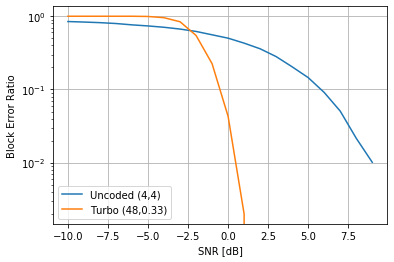

In [13]:
print('Plotting results')
plt.figure()
plt.grid(True)
plt.semilogy(snrs_db, bler_unc)
plt.semilogy(snrs_db, bler_turbo)
plt.xlabel('SNR [dB]')
plt.ylabel('Block Error Ratio')
plt.legend(['Uncoded (4,4)', 'Turbo (48,0.33)'], loc = 'lower left')
plt.show()